<a href="https://colab.research.google.com/github/suhaib2421/Machine-Learning-GRACC-Outlier-Detection/blob/master/ML_GRACC_Outlier_Detection_Suhaib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# All the imports/libraries needed 
!pip install -U -q elasticsearch elasticsearch_dsl numpy scipy sklearn
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import matplotlib.font_manager
import elasticsearch
from elasticsearch_dsl import Search, Q, A
import urllib3
import math
import datetime
import sklearn
from pandas.io.json import json_normalize
import pandas as pd

# Get rid of insecure warning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [ ]:
es = elasticsearch.Elasticsearch(
        ['https://gracc.opensciencegrid.org/q'],
        timeout=300, use_ssl=True, verify_certs=False)

/usr/local/lib/python3.6/dist-packages/elasticsearch/connection/http_urllib3.py:193: UserWarning: Connecting to https://gracc.opensciencegrid.org:443 using SSL with verify_certs=False is insecure.
  % self.host


In [ ]:
def metrics():

  osg_summary_index = 'gracc.osg.summary'
  s = Search(using=es, index=osg_summary_index)
  
  end_time = datetime.datetime.now()   # The end time is today
  start_time = end_time - datetime.timedelta(days=365)   # Start day is a year ago from today
  
  s = s.query('bool',
          filter=[
              Q('range', EndTime={'gt': start_time, 'lt': end_time })
            & Q('term', ResourceType='Batch')
          ]
      )

  a = A("terms", field="SiteName", size=(2**31)-1)  
  b = A("terms", field="VOName", size=(2**31)-1) 
  curBucket = s.aggs.bucket("probe_terms", a)
  curBucket = curBucket.bucket("vonames", b)
  curBucket = curBucket.bucket("EndTime", 'date_histogram', field="EndTime", interval="7d")

  bkt = curBucket
  bkt = bkt.metric('WallDuration',       'sum', field='WallDuration', missing = 0)
  bkt = bkt.metric('NumberOfJobs',       'sum', field='Count', missing = 0)
  bkt = bkt.metric('EarliestEndTime',    'min', field='EndTime')
  bkt = bkt.metric('LatestEndTime',      'max', field='EndTime')
  bkt = bkt.metric('CoreHours',          'sum', field='CoreHours', missing = 0)
  response = s.execute() # Creates a bucket with different metrics such as wall duration, core hours, # jobs, etc.

  probes = {}
  for bucket in response.aggregations['probe_terms']['buckets']:
    probes[bucket['key']] = pd.DataFrame(columns=['Timestamp', 'VO', 'CoreHours'])
    for voname in bucket['vonames']['buckets']:
      for endtime in voname['EndTime']['buckets']:
        #print({'Timestamp': endtime['key'], 'VO': voname['key'], 'CoreHours': endtime['CoreHours']['value']})
        probes[bucket['key']] = probes[bucket['key']].append({'Timestamp': endtime['key'], 'VO': voname['key'], 'CoreHours': endtime['CoreHours']['value']}, ignore_index=True)
    


  
  #df = pd.DataFrame(list(probes.items()), columns= ['Site Names', 'Core Hours'])
  #print(type(df))

  return probes

In [ ]:
# metrics()
# print(metrics())
all_ces = metrics()


0
Failed array: []
Test array: [[datetime.datetime(2020, 7, 16, 0, 0) 0 264.64666666666665]
 [datetime.datetime(2020, 7, 23, 0, 0) 0 2743.9266666666667]
 [datetime.datetime(2020, 7, 30, 0, 0) 0 28143.013333333332]
 [datetime.datetime(2020, 7, 16, 0, 0) 1 388.6944444444444]
 [datetime.datetime(2020, 7, 23, 0, 0) 1 5443.356666666667]
 [datetime.datetime(2020, 7, 30, 0, 0) 1 40746.25]
 [datetime.datetime(2020, 7, 16, 0, 0) 2 2.2955555555555556]
 [datetime.datetime(2020, 7, 23, 0, 0) 2 54.12888888888888]
 [datetime.datetime(2020, 7, 30, 0, 0) 2 323.77555555555557]
 [datetime.datetime(2020, 7, 16, 0, 0) 3 125.12666666666667]
 [datetime.datetime(2020, 7, 23, 0, 0) 3 4544.685555555556]
 [datetime.datetime(2020, 7, 30, 0, 0) 3 8272.638888888889]
 [datetime.datetime(2020, 7, 16, 0, 0) 4 35.03888888888889]
 [datetime.datetime(2020, 7, 23, 0, 0) 4 1561.5266666666664]
 [datetime.datetime(2020, 7, 30, 0, 0) 4 13549.378888888888]
 [datetime.datetime(2020, 7, 16, 0, 0) 5 52.51222222222222]
 [datetime

IndexError: ignored

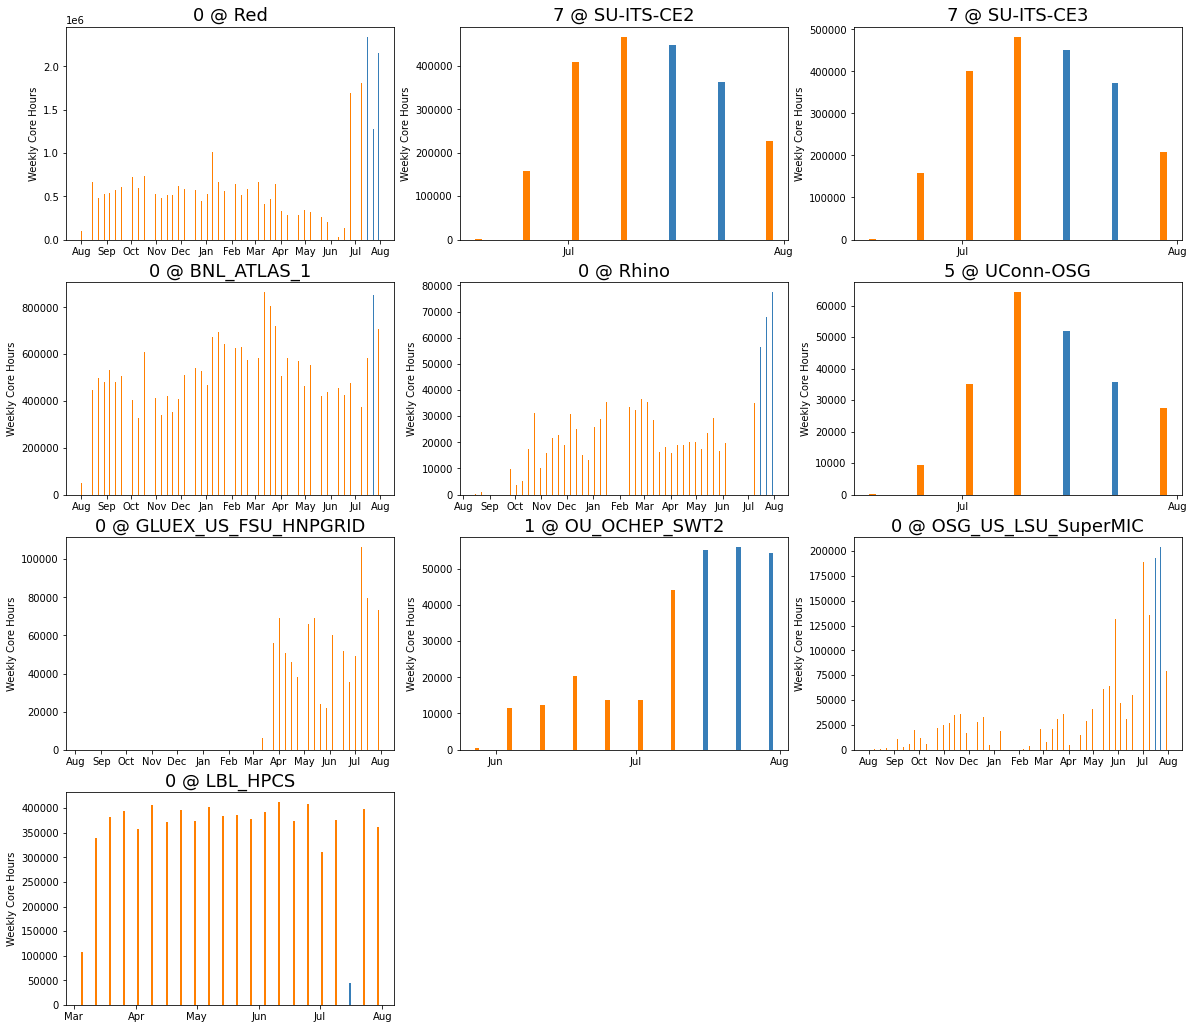

In [ ]:
from sklearn.ensemble import IsolationForest  # Need to learn what Isolation Forest does

test_days = 3
plot_num = 1
num_outliers = 0
new_array = []
plt.figure(figsize=(20, 140))
# print(len(probes))

class ml:

  def __init__(self):
    self.voname_map = {}

  def vo_record(self, row):
    for record in metrics()[outlier]:   # What is a record?
      if record[1] not in outlier()[voname_map]:
        # print(record[1])   #I'm unsure what this is doing, because it is just printing out a bunch of numbers
        new_id = len(outlier(voname_map))
        voname_map[record[1]] = new_id
      record[1] = voname_map[record[1]]
      print(record[1])
    return record[1]


  def outlier(self, voname_map):
    #all_ces =  metrics()
    num_outliers = 0
    plot_num = 1
    for interested_probe in all_ces:
      current_ce = all_ces[interested_probe]
      # Enumerate the VONames
      voname_map = {}
      for index, row in current_ce.iterrows():   # What is a record?
        if row['VO'] not in voname_map:
          new_id = len(voname_map)
          voname_map[row['VO']] = new_id
        current_ce.at[index, 'VO'] = voname_map[row['VO']]
      
      new_array = []
      #print(interested_probe)
      num_days = len(current_ce)
      
      # Make sure there's enough days to test
      if num_days < (test_days*3):
        continue
        
      # Make sure the last days are within a few days of now
      last_day = datetime.datetime.fromtimestamp(current_ce.tail(1)['Timestamp']/1000)
      if last_day > (datetime.datetime.now() - datetime.timedelta(days=test_days*2)): # <--- Fix this line, I forget what it was before, all_ces needs to indexed into
        continue
      
      # Only use the columns 1 and 2  ### ***What is column 1 and 2?***
      #new_array = np.array(current_ce)
      
      #print(probes[interested_probe])   # What are these values supposed to represent?
      #for z in probes[interested_probe]:
      #  new_array.append([z[2], z[2]])
      #date_array = np.array(probes[interested_probe])
      date_array = np.array(current_ce)
      
      
      # Convert from milliseconds to seconds in the timestamp column
      # I'm sure you can do this with current_ce['Timestamp'] / 1000 or something.
      def convert_datetime(array):
        #print(array[0])
        return np.array([datetime.datetime.fromtimestamp(array[0]/1000), array[1], array[2]])
              
      date_array = np.apply_along_axis(convert_datetime, 1, date_array)
      #print(new_array[:88])
      
      np_array = [] # training array
      test_array = []
      # Split the data into test and train
      for row in date_array:
        if row[0] < (datetime.datetime.now() - datetime.timedelta(days=test_days*7)):  
          np_array.append(row)
        else:
          test_array.append(row)  
      np_array = np.array(np_array)
      test_array = np.array(test_array)

      # If we don't have enough test days, then ignore this CE
      # This can happen if the CE hasn't been active in a while, ie, no new data.
      # Really, we should extend 0's for all the days we don't have, and it should probably
      # show up as an outlier
      if len(test_array) < test_days:
        continue
      
      #np_array = np.array(new_array[:num_days-test_days])
      #print(np_array)
      #test_array = np.array(new_array[-test_days:])
      #print(np_array)
      outliers_fraction = .01  # Percentage of observations we believe to be outliers
      #print("Testing against array of size:", np_array.shape)
      iso_forest = IsolationForest(contamination=outliers_fraction, random_state=42)
      try:
        y_pred = iso_forest.fit(np_array[:,[1,2]]).predict(test_array[:,[1,2]])
      except:
        print("Failed array:", np_array)
        print("Test array:", test_array)
        raise
        continue
      colors = np.array(['#377eb8', '#ff7f00'])
      #print(y_pred)
      outlier = False

      # Converting from the numbers back to the VO names
      inverted_voname_map = dict([[v,k] for k,v in voname_map.items()])
      outlier_vos = []
      for idx, pred in enumerate(y_pred):
        if pred == -1:
          #print(inverted_voname_map)
          #print(voname_map)
          outlier_vo = test_array[idx][1]
          #print("Outlier:", interested_probe, "VOName:", outlier_vo)
          outlier_vos.append(outlier_vo)
          outlier = True
      
      outlier_vos = set(outlier_vos)
      # Add the "outlier" column to the arrays
      np_array = np.append(np_array, np.ones([len(np_array),1], dtype=np.int8),1)
      test_array = np.append(test_array, y_pred[...,None], 1)
      total_array = np.concatenate((np_array, test_array))
      
      for outlier_vo in outlier_vos:

        to_graph = []
        # Create the graphing array
        for row in total_array:
          if int(row[1]) != outlier_vo:
            #print(row[1], outlier_vo)
            continue
          to_graph.append(row)
            

        to_graph = np.array(to_graph)
        #print(to_graph.shape)
        ax_now = plt.subplot(30, 3, plot_num)
        #print(to_graph[:, 2])

        #new_plt = ax_now.scatter(date_array[:, 0].astype("datetime64[ns]"), date_array[:, 2])# , s=10, color=colors[(to_graph[:, 3].astype(int) + 1) // 2])
        new_plt = ax_now.bar(to_graph[:, 0].astype("datetime64[ns]"), to_graph[:, 2], width=0.99, color=colors[(to_graph[:, 3].astype(int) + 1) // 2]) # width=3
        #outliers = to_graph.loc[to_graph[3] == 1]
        #print(outliers)
        plt.title("{} @ {}".format(inverted_voname_map[int(outlier_vo)], interested_probe), size=18)
        #ax_now.text(.99, .01, "Outlier",
        #               transform=plt.gca().transAxes, size=15,
        #               horizontalalignment='right')
        months = mdates.MonthLocator()  # every month
        monthsFmt = mdates.DateFormatter('%b')
        ax_now.xaxis.set_major_locator(months)
        ax_now.xaxis.set_major_formatter(monthsFmt)
        plt.ylabel("Weekly Core Hours")

        plot_num += 1
        num_outliers += 1
        
        #return voname_map

      #print(num_outliers)
    


print(num_outliers)
ml = ml()
ml.outlier(None)
plt.show()
  